ValerioVelardo The Sound of AI Generating Sound with Neural Networks 영상을 보며 코드 작성 하였습니다.

In [ ]:
import os
import pickle
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras import backend as K #variable을 생성 및 연산가능
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import tensorflow as tf
from tensorflow.keras.datasets import mnist

VAE Network

In [ ]:
import os
import pickle
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

class VAE:
    """
    VAE represents a Deep Convolutional variational autoencoder architectu with mirrored encoder and decoder components.
    """

    def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim):
        self.input_shape = input_shape # (256, 64, 1),
        self.conv_filters = conv_filters # (512, 256, 128, 64, 32),
        self.conv_kernels = conv_kernels # (3, 3, 3, 3, 3),
        self.conv_strides = conv_strides # (2, 2, 2, 2, (2, 1)),
        self.latent_space_dim = latent_space_dim # 128
        self.reconstruction_loss_weight = 1000

        self.encoder = None
        self.decoder = None
        self.model = None

        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self._model_input = None

        self._build()

    #모델 네트워크 확인
    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary()

    #모델 컴파일 (optimizer, loss)
    def compile(self, learning_rate=0.0001):
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer,
                           loss=self._calculate_combined_loss,
                           metrics=[self._calculate_reconstruction_loss, #matric custom
                                    self._calculate_kl_loss])

    #모델 학습
    def train(self, x_train, batch_size, num_epochs):
        self.model.fit(x_train,
                       x_train, # AE는 결과가 같은 데이터를 나오게하는것이기 때문에 y값에도 x_train을 넣는다
                       batch_size=batch_size,
                       epochs=num_epochs,
                       shuffle=True)
    #weight 경로 저장  
    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    #weight 경로 호출
    def load_weights(self, weights_path):
        self.model.load_weights(weights_path)

    def reconstruct(self, images):
        latent_representations = self.encoder.predict(images)
        reconstructed_images = self.decoder.predict(latent_representations)
        return reconstructed_images, latent_representations

    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = VAE(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5")
        autoencoder.load_weights(weights_path)
        return autoencoder

    '''
    only VAE
    '''
    def _calculate_combined_loss(self, y_target, y_predicted):
        reconstruction_loss = self._calculate_reconstruction_loss(y_target, y_predicted)
        kl_loss = self._calculate_kl_loss(y_target, y_predicted)
        combined_loss = self.reconstruction_loss_weight * reconstruction_loss + kl_loss
        return combined_loss

    '''
    only VAE
    '''
    def _calculate_reconstruction_loss(self, y_target, y_predicted):
        error = y_target - y_predicted
        reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3])
        return reconstruction_loss

    '''
    only VAE
    '''
    def _calculate_kl_loss(self, y_target, y_predicted):
        kl_loss = -0.5 * K.sum(1 + self.log_variance - K.square(self.mu) - K.exp(self.log_variance), axis=1)
        return kl_loss

    #경로 폴더 생성
    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    #파라미터 저장
    def _save_parameters(self, save_folder):
        parameters = [
            self.input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    #가중치 저장
    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5")
        self.model.save_weights(save_path)

    #네트워크 빌드
    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder()

    #네트워크 
    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name="autoencoder")



    """
    DECODER
    """
    
    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.decoder = Model(decoder_input, decoder_output, name="decoder")

    def _add_decoder_input(self):
        return Input(shape=self.latent_space_dim, name="decoder_input")

    def _add_dense_layer(self, decoder_input):
        num_neurons = np.prod(self._shape_before_bottleneck) # [1, 2, 4] -> 8
        dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
        return dense_layer

    def _add_reshape_layer(self, dense_layer):
        return Reshape(self._shape_before_bottleneck)(dense_layer)

    def _add_conv_transpose_layers(self, x):
        """Add conv transpose blocks."""
        # loop through all the conv layers in reverse order and stop at the
        # first layer
        for layer_index in reversed(range(1, self._num_conv_layers)):
            x = self._add_conv_transpose_layer(layer_index, x)       # [1,2] -> [2,1] 3개의 레이어라고 하면 첫 번째는 신경쓰지 않는다.
        return x

    def _add_conv_transpose_layer(self, layer_index, x):
        layer_num = self._num_conv_layers - layer_index
        conv_transpose_layer = Conv2DTranspose(
            filters=self.conv_filters[layer_index], #[24,24,1]
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"decoder_conv_transpose_layer_{layer_num}"
        )
        x = conv_transpose_layer(x)
        x = ReLU(name=f"decoder_relu_{layer_num}")(x)
        x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
        return x

    def _add_decoder_output(self, x):
        conv_transpose_layer = Conv2DTranspose(
            filters=1,
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
        )
        x = conv_transpose_layer(x)
        output_layer = Activation("sigmoid", name="sigmoid_layer")(x)
        return output_layer

    """
    ENCODER
    """

    def _build_encoder(self):
        encoder_input = self._add_encoder_input()
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self._model_input = encoder_input
        self.encoder = Model(encoder_input, bottleneck, name="encoder")

    def _add_encoder_input(self):
        return Input(shape=self.input_shape, name="encoder_input")

    def _add_conv_layers(self, encoder_input):
        """Create all convolutional blocks in encoder."""
        x = encoder_input
        for layer_index in range(self._num_conv_layers):
            x = self._add_conv_layer(layer_index, x)
        return x

    def _add_conv_layer(self, layer_index, x):
        """Add a convolutional block to a graph of layers, consisting of
        conv 2d + ReLU + batch normalization.
        """
        layer_number = layer_index + 1
        conv_layer = Conv2D(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"encoder_conv_layer_{layer_number}"
        )
        x = conv_layer(x)
        x = ReLU(name=f"encoder_relu_{layer_number}")(x)
        x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
        return x

    #변경
    def _add_bottleneck(self, x):
        """Flatten data and add bottleneck with Guassian sampling (Dense
        layer).
        """

        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = Flatten()(x) #bottle neck key: 1x1 conv
        #VAE
        self.mu = Dense(self.latent_space_dim, name="mu")(x) #평균
        self.log_variance = Dense(self.latent_space_dim, name="log_variance")(x) #분산

        def sample_point_from_normal_distribution(args):
            mu, log_variance = args
            epsilon = K.random_normal(shape=K.shape(self.mu), mean=0.,stddev=1.) #임의의 작은 양수
            sampled_point = mu + K.exp(log_variance / 2) * epsilon 
            return sampled_point

        x = Lambda(sample_point_from_normal_distribution, name="encoder_output")([self.mu, self.log_variance])
        return x


In [ ]:
from tensorflow.keras.datasets import mnist

LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 10#50


def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype("float32") / 255
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.astype("float32") / 255
    x_test = x_test.reshape(x_test.shape + (1,))

    return x_train, y_train, x_test, y_test


def train(x_train, learning_rate, batch_size, epochs):
    print('0')
    autoencoder = VAE(
        input_shape=(28, 28, 1),
        conv_filters=(32, 64, 64, 64),
        conv_kernels=(3, 3, 3, 3),
        conv_strides=(1, 2, 2, 1),
        latent_space_dim=20 #2
    )
    
    # autoencoder.summary()
    autoencoder.compile(learning_rate)
    print("check1")
    autoencoder.train(x_train, batch_size, epochs)
    return autoencoder


if __name__ == "__main__":
    x_train, _, _, _ = load_mnist()
    autoencoder = train(x_train[:10000], LEARNING_RATE, BATCH_SIZE, EPOCHS)
    autoencoder.save("vae_model")

0
check1
Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 13s 1ms/sample - loss: 88.9286 - _calculate_reconstruction_loss: 0.0709 - _calculate_kl_loss: 18.0232
Epoch 2/10
10000/10000 [==============================] - 15s 2ms/sample - loss: 50.7751 - _calculate_reconstruction_loss: 0.0349 - _calculate_kl_loss: 15.8632
Epoch 3/10
10000/10000 [==============================] - 10s 1ms/sample - loss: 45.5554 - _calculate_reconstruction_loss: 0.0292 - _calculate_kl_loss: 16.3392
Epoch 4/10
10000/10000 [==============================] - 7s 732us/sample - loss: 41.8100 - _calculate_reconstruction_loss: 0.0262 - _calculate_kl_loss: 15.6054
Epoch 5/10
10000/10000 [==============================] - 7s 719us/sample - loss: 40.4599 - _calculate_reconstruction_loss: 0.0249 - _calculate_kl_loss: 15.5826
Epoch 6/10
10000/10000 [==============================] - 7s 711us/sample - loss: 40.8264 - _calculate_reconstruction_loss: 0.0246 - _calculate_kl_loss: 16.1810
Epoch

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


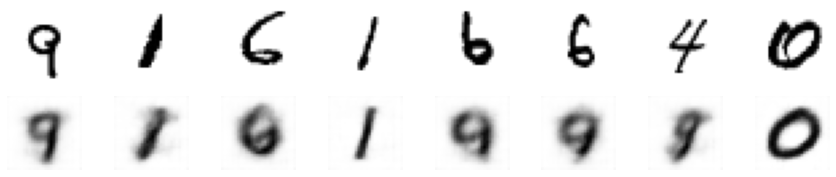

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def select_images(images, labels, num_images=10):
    sample_images_index = np.random.choice(range(len(images)), num_images)
    sample_images = images[sample_images_index]
    sample_labels = labels[sample_images_index]
    return sample_images, sample_labels


def plot_reconstructed_images(images, reconstructed_images):
    fig = plt.figure(figsize=(15, 3))
    num_images = len(images)
    for i, (image, reconstructed_image) in enumerate(zip(images, reconstructed_images)):
        image = image.squeeze()
        ax = fig.add_subplot(2, num_images, i + 1)
        ax.axis("off")
        ax.imshow(image, cmap="gray_r")
        reconstructed_image = reconstructed_image.squeeze()
        ax = fig.add_subplot(2, num_images, i + num_images + 1)
        ax.axis("off")
        ax.imshow(reconstructed_image, cmap="gray_r")
    plt.show()


def plot_images_encoded_in_latent_space(latent_representations, sample_labels):
    plt.figure(figsize=(10, 10))
    plt.scatter(latent_representations[:, 0],
                latent_representations[:, 1],
                cmap="rainbow",
                c=sample_labels,
                alpha=0.5,
                s=2)
    plt.colorbar()
    plt.show()

#Latent space= 2
if __name__ == "__main__":
    autoencoder = VAE.load("vae_model")
    x_train, y_train, x_test, y_test = load_mnist()

    num_sample_images_to_show = 8
    sample_images, _ = select_images(x_test, y_test, num_sample_images_to_show)
    reconstructed_images, _ = autoencoder.reconstruct(sample_images)
    plot_reconstructed_images(sample_images, reconstructed_images)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


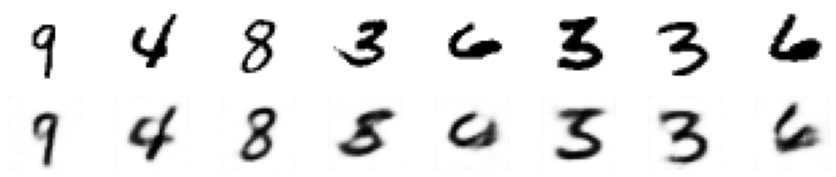

In [ ]:
# Latent space= 20

##### TRAIN ISSUE 해결

In [ ]:
!pip install tensorflow==2.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.7 MB 18 kB/s 
     |████████████████████████████████| 14.8 MB 56.1 MB/s 
     |████████████████████████████████| 3.8 MB 52.4 MB/s 
     |████████████████████████████████| 2.9 MB 49.9 MB/s 
     |████████████████████████████████| 132 kB 78.6 MB/s 
     |████████████████████████████████| 462 kB 68.5 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68717 sha256=f03431b430faa982f56ef0885c7ffae07ec3539a6a64d7eba0aaaaa8f950334c
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: n

# DATA

In [ ]:
import librosa
import numpy as np
import os
import pickle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
1- load a file
2- pad the signal (if necessary)
3- extracting log spectrogram from signal
4- normalise spectrogram
5- save the normalised spectrogram
PreprocessingPipeline
"""

class Loader:
  """Loader is responsible for loading an audio file."""

  def __init__(self, sample_rate, duration, mono):
    self.sample_rate = sample_rate
    self.duration = duration
    self.mono = mono

  def load(self, file_path):
    signal = librosa.load(file_path,
                          sr=self.sample_rate,
                          duration=self.duration,
                          mono=self.mono)[0]
    return signal


class Padder:
  """Padder is responsible to apply padding to an array."""

  def __init__(self, mode="constant"):
    self.mode = mode

  # def left_pad(self, array, num_missing_items):
  #   padded_array = np.pad(array,
  #                         (num_missing_items, 0),
  #                         mode=self.mode)
  #   return padded_array

  def right_pad(self, array, num_missing_items):
    padded_array = np.pad(array,
                          (0, num_missing_items),
                          mode=self.mode)
    return padded_array


class LogSpectrogramExtractor:
  """LogSpectrogramExtractor extracts log spectrograms (in dB) from a
  time-series signal.
  """

  def __init__(self, frame_size, hop_length):
    self.frame_size = frame_size
    self.hop_length = hop_length

  def extract(self, signal):
    stft = librosa.stft(signal,
                        n_fft=self.frame_size,
                        hop_length=self.hop_length)[:-1]
    spectrogram = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    return log_spectrogram


class MinMaxNormaliser:
  """MinMaxNormaliser applies min max normalisation to an array."""

  def __init__(self, min_val, max_val):
    self.min = min_val
    self.max = max_val

  def normalise(self, array):
    norm_array = (array - array.min()) / (array.max() - array.min()) #Normalise식은 여기까지,
    norm_array = norm_array * (self.max - self.min) + self.min # ???
    return norm_array

  def denormalise(self, norm_array, original_min, original_max):
    array = (norm_array - self.min) / (self.max - self.min)
    array = array * (original_max - original_min) + original_min
    return array


class Saver:
  """saver is responsible to save features, and the min max values."""

  def __init__(self, feature_save_dir, min_max_values_save_dir):
    self.feature_save_dir = feature_save_dir
    self.min_max_values_save_dir = min_max_values_save_dir

  def save_feature(self, feature, file_path):
      save_path = self._generate_save_path(file_path)
      np.save(save_path, feature) #save_path, feature
      return save_path

  def save_min_max_values(self, min_max_values):
    save_path = os.path.join(self.min_max_values_save_dir,
                              "min_max_values.pkl")
    self._save(min_max_values, save_path)

  @staticmethod #파이썬에서는 정적메소드임에도 불구하고 인스턴스에서도 접근이 가능하다.
  def _save(data, save_path):
    with open(save_path, "wb") as f:
        pickle.dump(data, f)

  def _generate_save_path(self, file_path):
    file_name = os.path.split(file_path)[1]
    save_path = os.path.join(self.feature_save_dir, file_name + ".npy")
    return save_path

class PreprocessingPipeline:
  """PreprocessingPipeline processes audio files in a directory, applying
  the following steps to each file:
    1- load a file
    2- pad the signal (if necessary)
    3- extracting log spectrogram from signal
    4- normalise spectrogram
    5- save the normalised spectrogram
  Storing the min max values for all the log spectrograms.
  """
  # FRAME_SIZE = 512
  # HOP_LENGTH = 256
  # DURATION = 0.74  # in seconds
  # SAMPLE_RATE = 22050
  # MONO = True

  def __init__(self):
    self.padder = None
    self.extractor = None
    self.normaliser = None
    self.saver = None
    self.min_max_values = {}
    self._loader = None
    self._num_expected_samples = None

  @property #getter
  def loader(self):
    return self._loader

  @loader.setter #setter
  def loader(self, loader):
    self._loader = loader
    self._num_expected_samples = int(loader.sample_rate * loader.duration) #16317

  def process(self, audio_files_dir):
    for root, _, files in os.walk(audio_files_dir):
        for file in files:
            file_path = os.path.join(root, file)
            self._process_file(file_path)
            print(f"Processed file {file_path}")
    self.saver.save_min_max_values(self.min_max_values)

  def _process_file(self, file_path): #_로 시작하는 변수는 외부에서 직접 접근하지 않는것이 파이썬의 관행이라고 한다.
    signal = self.loader.load(file_path)
    if self._is_padding_necessary(signal):  #padding 필요여부
        signal = self._apply_padding(signal)
    feature = self.extractor.extract(signal) #log_spectrogram_extractor
    norm_feature = self.normaliser.normalise(feature) # min_max_normaliser
    print(f'file_path->{file_path}')
    save_path = self.saver.save_feature(norm_feature, file_path)
    self._store_min_max_value(save_path, feature.min(), feature.max())

  def _is_padding_necessary(self, signal):
    if len(signal) < self._num_expected_samples: #int(loader.sample_rate * loader.duration)
        return True
    return False

  def _apply_padding(self, signal):
    num_missing_samples = self._num_expected_samples - len(signal) 
    padded_signal = self.padder.right_pad(signal, num_missing_samples)
    return padded_signal

  def _store_min_max_value(self, save_path, min_val, max_val):
    print(f'min->{min_val},max->{max_val}')

    self.min_max_values[save_path] ={
    "min": min_val,
    "max": max_val
    }

In [ ]:
if __name__ == "__main__":
  FRAME_SIZE = 512
  HOP_LENGTH = 256
  DURATION = 0.74  # in seconds
  SAMPLE_RATE = 22050
  MONO = True

  SPECTROGRAMS_SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/ML/FSDD/spectrograms/"
  MIN_MAX_VALUES_SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/ML/FSDD/"
  FILES_DIR = "/content/drive/MyDrive/Colab Notebooks/ML/FSDD/recordings/"


  # instantiate all objects
  loader = Loader(SAMPLE_RATE, DURATION, MONO)
  padder = Padder()
  log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
  min_max_normaliser = MinMaxNormaliser(0, 1)
  saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)

  preprocessing_pipeline = PreprocessingPipeline()
  preprocessing_pipeline.loader = loader
  preprocessing_pipeline.padder = padder
  preprocessing_pipeline.extractor = log_spectrogram_extractor
  preprocessing_pipeline.normaliser = min_max_normaliser
  preprocessing_pipeline.saver = saver

  preprocessing_pipeline.process(FILES_DIR)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
min->-69.19367218017578,max->10.806329727172852
Processed file /content/drive/MyDrive/Colab Notebooks/ML/FSDD/recordings/2_yweweler_18.wav
file_path->/content/drive/MyDrive/Colab Notebooks/ML/FSDD/recordings/5_george_42.wav
min->-55.73857116699219,max->24.261428833007812
Processed file /content/drive/MyDrive/Colab Notebooks/ML/FSDD/recordings/5_george_42.wav
file_path->/content/drive/MyDrive/Colab Notebooks/ML/FSDD/recordings/6_jackson_38.wav
min->-42.5394287109375,max->37.4605712890625
Processed file /content/drive/MyDrive/Colab Notebooks/ML/FSDD/recordings/6_jackson_38.wav
file_path->/content/drive/MyDrive/Colab Notebooks/ML/FSDD/recordings/4_jackson_43.wav
min->-49.50846862792969,max->30.491533279418945
Processed file /content/drive/MyDrive/Colab Notebooks/ML/FSDD/recordings/4_jackson_43.wav
file_path->/content/drive/MyDrive/Colab Notebooks/ML/FSDD/recordings/6_jackson_46.wav
min->-48.25636291503906,max->31.743637084960938
Processed file /content/

In [ ]:
import os

import numpy as np

LEARNING_RATE = 0.0005
BATCH_SIZE = 64
EPOCHS = 30#150

SPECTROGRAMS_PATH = "/content/drive/MyDrive/Colab Notebooks/ML/FSDD/spectrograms/" #wav.npy


def load_fsdd(spectrograms_path):
  x_train = []
  for root, _, file_names in os.walk(spectrograms_path):
      for file_name in file_names:
          file_path = os.path.join(root, file_name)
          spectrogram = np.load(file_path) # (n_bins, n_frames, 1)
          x_train.append(spectrogram)
  x_train = np.array(x_train)
  x_train = x_train[..., np.newaxis] # -> (3000, 256, 64, 1)
  return x_train

def train(x_train, learning_rate, batch_size, epochs):
  autoencoder = VAE(
      input_shape=(256, 64, 1),
      conv_filters=(512, 256, 128, 64, 32),
      conv_kernels=(3, 3, 3, 3, 3),
      conv_strides=(2, 2, 2, 2, (2, 1)),
      latent_space_dim=128
  )
  # autoencoder.summary()
  autoencoder.compile(learning_rate)
  autoencoder.train(x_train, batch_size, epochs)
  return autoencoder


if __name__ == "__main__":
  x_train = load_fsdd(SPECTROGRAMS_PATH)
  autoencoder = train(x_train, LEARNING_RATE, BATCH_SIZE, EPOCHS)
  autoencoder.save("test_model")

check3
0
Train on 3000 samples
Epoch 1/30
3000/3000 [==============================] - 44s 15ms/sample - loss: 194.2659 - _calculate_reconstruction_loss: 0.1662 - _calculate_kl_loss: 28.0807
Epoch 2/30
3000/3000 [==============================] - 25s 8ms/sample - loss: 55.6165 - _calculate_reconstruction_loss: 0.0490 - _calculate_kl_loss: 6.5696
Epoch 3/30
3000/3000 [==============================] - 26s 9ms/sample - loss: 29.2895 - _calculate_reconstruction_loss: 0.0251 - _calculate_kl_loss: 4.1528
Epoch 4/30
3000/3000 [==============================] - 26s 9ms/sample - loss: 23.5574 - _calculate_reconstruction_loss: 0.0199 - _calculate_kl_loss: 3.6565
Epoch 5/30
3000/3000 [==============================] - 26s 9ms/sample - loss: 21.2456 - _calculate_reconstruction_loss: 0.0181 - _calculate_kl_loss: 3.1729
Epoch 6/30
3000/3000 [==============================] - 27s 9ms/sample - loss: 19.6948 - _calculate_reconstruction_loss: 0.0169 - _calculate_kl_loss: 2.7649
Epoch 7/30
3000/3000 [==

### Generating Sound Digits

In [ ]:
class SoundGenerator:
  """SoundGenerator is responsible for generating audios from spectrograms"""
  def __init__(self, vae, hop_length):
    self.vae = vae
    self.hop_length = hop_length
    self._min_max_normaliser = MinMaxNormaliser(0,1)

  def generate(self, spectrgrams, min_max_values):
    generated_spectrograms, latent_representations = self.vae.reconstruct(spectrgrams)
    signals = self.convert_spectrograms_to_audio(generated_spectrograms, min_max_values)
    return signals, latent_representations

  def convert_spectrograms_to_audio(self, spectrograms, min_max_values):
    signals = []
    for spectrogram, min_max_value in zip(spectrograms, min_max_values):
      # reshape the log spectrogram 
      log_spectrogram = spectrogram[:,:,0] #세번째 차원 삭제
      # apply denormalisation
      denorm_log_spec = self._min_max_normaliser.denormalise(log_spectrogram, min_max_value["min"],min_max_value["max"])
      # log spectrogram -> spectrogram db to 일반 데시벨
      spec = librosa.db_to_amplitude(denorm_log_spec)
      # apply ISTFT (Griffin-Lim가능?)
      signal = librosa.istft(spec, hop_length=self.hop_length)
      # append signal to "signals"
      signals.append(signal)
    return signals

### Generate

In [ ]:
import os
import pickle

import numpy as np
import soundfile as sf

HOP_LENGTH = 256
SAVE_DIR_ORIGINAL = "/content/drive/MyDrive/Colab Notebooks/ML/FSDD/samples/original/"
SAVE_DIR_GENERATED = "/content/drive/MyDrive/Colab Notebooks/ML/FSDD/samples/generated/"
MIN_MAX_VALUES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML/FSDD/min_max_values.pkl"
SPECTROGRAMS_PATH = "/content/drive/MyDrive/Colab Notebooks/ML/FSDD/spectrograms/"

def load_fsdd(spectrograms_path):
    x_train = []
    file_paths = []
    for root, _, file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path) # (n_bins, n_frames, 1) 256,64
            x_train.append(spectrogram)
            file_paths.append(file_path) #n:3000
    x_train = np.array(x_train)
    x_train = x_train[..., np.newaxis] # (3000, 256, 64, 1)
    return x_train, file_paths


def select_spectrograms(spectrograms,
                        file_paths,
                        min_max_values,
                        num_spectrograms=2): #5개 샘플 테스트
    sampled_indexes = np.random.choice(range(len(spectrograms)), num_spectrograms)
    sampled_spectrogrmas = spectrograms[sampled_indexes]
    file_paths = [file_paths[index] for index in sampled_indexes]
    print("TEST->",min_max_values)

    sampled_min_max_values = [min_max_values[file_path] for file_path in file_paths]
    print(sampled_min_max_values)
    return sampled_spectrogrmas, sampled_min_max_values


def save_signals(signals, save_dir, sample_rate=22050):
    for i, signal in enumerate(signals):
        save_path = os.path.join(save_dir, str(i) + ".wav")
        sf.write(save_path, signal, sample_rate)

if __name__ == "__main__":
    # initialise sound generator
    vae = VAE.load("test_model")
    sound_generator = SoundGenerator(vae, HOP_LENGTH)

    # load spectrograms + min max values
    with open(MIN_MAX_VALUES_PATH, "rb") as f:
        min_max_values = pickle.load(f) 
        print("TEST1->",min_max_values)

    specs, file_paths = load_fsdd(SPECTROGRAMS_PATH)

    # sample spectrograms + min max values
    sampled_specs, sampled_min_max_values = select_spectrograms(specs,
                                                                file_paths,
                                                                min_max_values,
                                                                5)
    # generate audio for sampled spectrograms
    signals, _ = sound_generator.generate(sampled_specs,
                                          sampled_min_max_values)

    # convert spectrogram samples to audio
    original_signals = sound_generator.convert_spectrograms_to_audio(sampled_specs, sampled_min_max_values)

    # save audio signals
    save_signals(signals, SAVE_DIR_GENERATED)
    save_signals(original_signals, SAVE_DIR_ORIGINAL)

NameError: ignored